In [1]:
import torch

x = torch.randn(1, 23, 10)



In [2]:
def random_masking(x, mask_ratio=0.15):
    """
    Azzeramento casuale globale di valori in un tensore [B, C, T],
    secondo una percentuale `mask_ratio` dei valori totali.
    """
    # Crea una maschera booleana con valori True dove si vuole azzerare
    mask = torch.rand_like(x) < mask_ratio  # stessa shape di x
    x_masked = x.clone()
    x_masked[mask] = 0.0
    return x_masked, mask

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def visualize_masked_embedding( masked_emb, titolo):
    """
    Visualizza una griglia binaria dell'embedding mascherato:
    celle blu per valori zero, bianche altrimenti.
    """
    # Converti in numpy
    masked_emb_np = masked_emb.detach().cpu().numpy()

    # Rimuovi la dimensione di batch se presente (es. da [1, T, D] a [T, D])
    if masked_emb_np.ndim == 3 and masked_emb_np.shape[0] == 1:
        masked_emb_np = masked_emb_np[0]

    # Crea maschera binaria: 1 se valore è zero, 0 altrimenti
    binary_mask = (masked_emb_np == 0.0).astype(int)

    # Colori: 0 → bianco, 1 → blu
    cmap = ListedColormap(["white", "blue"])

    plt.figure(figsize=(12, 6))
    plt.imshow(binary_mask, aspect='auto', cmap=cmap)
    plt.title(titolo)
    plt.xlabel("Dimensione dell'Embedding")
    plt.ylabel("Sequenza Temporale")
    plt.grid(True, color='gray', linewidth=0.5, linestyle='--')
    plt.xticks(np.arange(masked_emb_np.shape[1]))
    plt.yticks(np.arange(masked_emb_np.shape[0]))
    plt.tight_layout()
    plt.show()

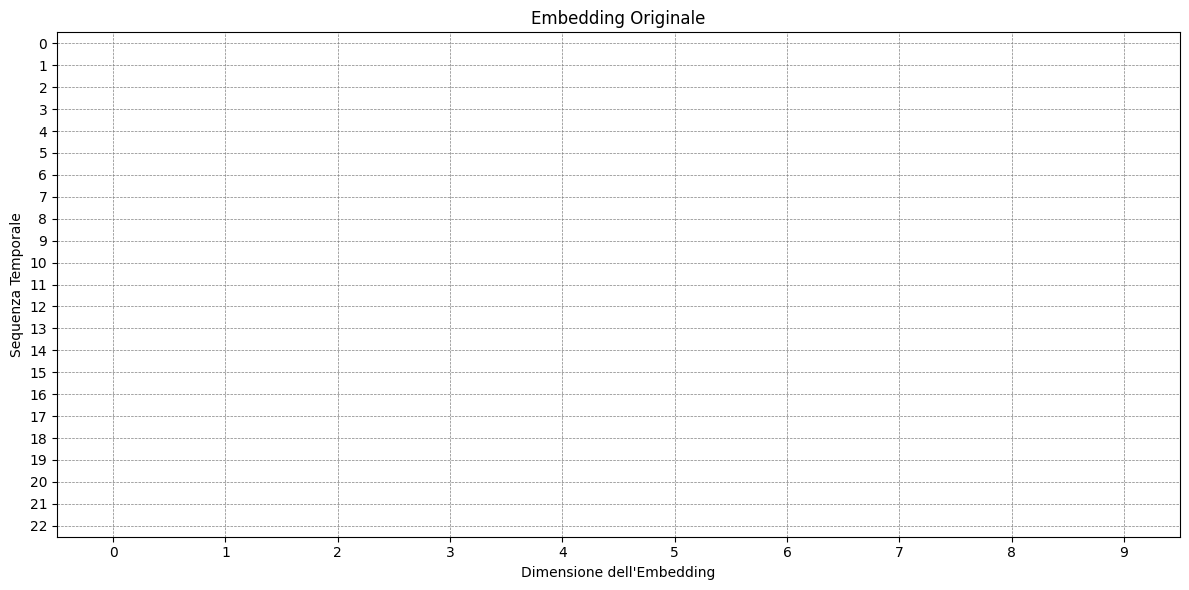

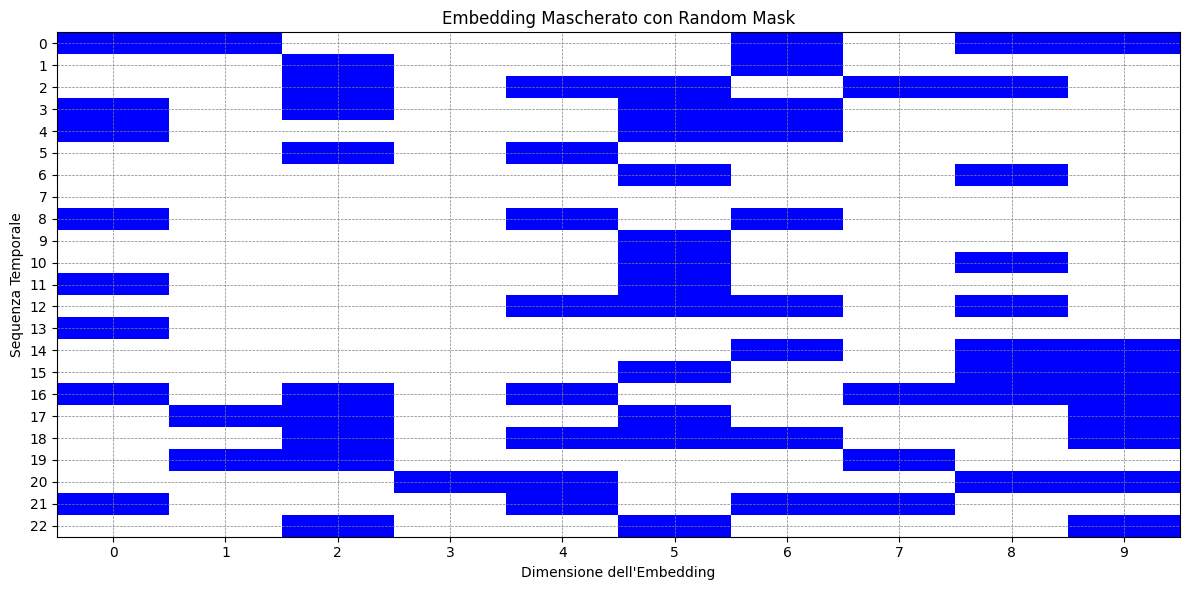

In [4]:
mask_emb, _ = random_masking(x, mask_ratio=0.3)
visualize_masked_embedding(x, "Embedding Originale")
visualize_masked_embedding(mask_emb, "Embedding Mascherato con Random Mask")


In [5]:
def random_masking_labram(x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)
        # mask = np.hstack([
        #     np.zeros(len_keep),
        #     np.ones(L - len_keep),
        # ])
        # np.random.shuffle(mask)

        return mask.to(torch.bool)

tensor([[False, False,  True, False,  True, False, False, False,  True, False,
         False, False,  True, False, False, False, False,  True,  True, False,
         False, False,  True]])


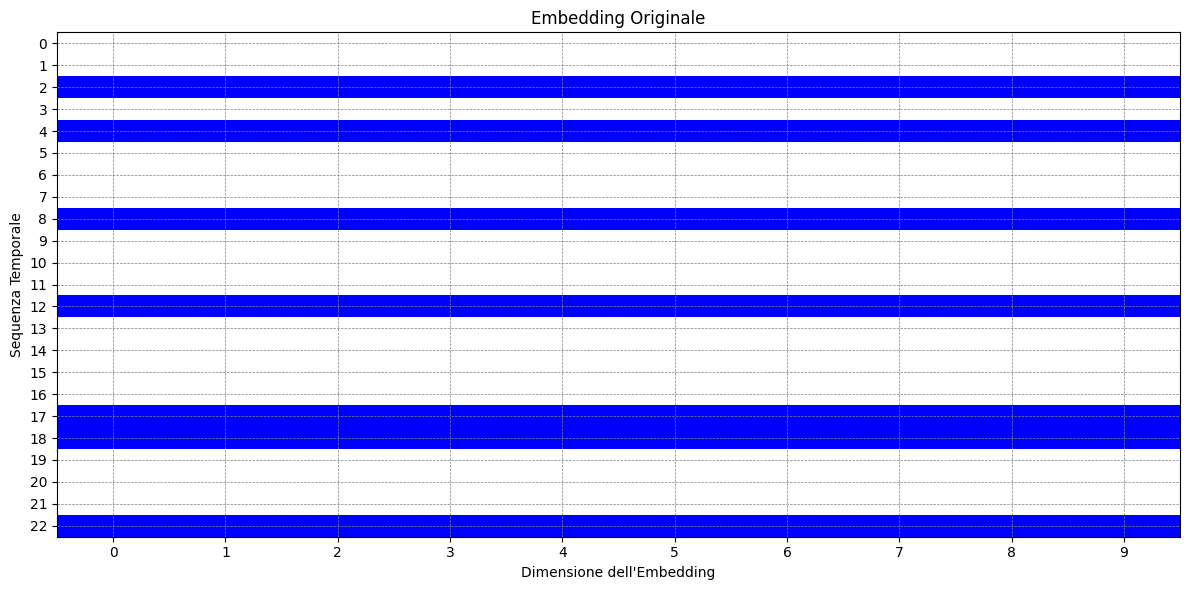

torch.Size([1, 23, 10])


In [11]:
bool_mask = random_masking_labram(x, mask_ratio=0.3)
print(bool_mask)

# Use the mask to filter out the embeddings and visualize
masked_x = x.clone()
masked_x[bool_mask] = 0.0
visualize_masked_embedding(masked_x, "Embedding Originale")
print(masked_x.shape)

